# Classification of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp

# Load data

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [3]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [4]:
s = [x for x in acidoCEST_ML.shape]
print( f'data size | rows = {s[0]:,}, cols = {s[1]:,}' )

data size | rows = 20,000, cols = 88


In [5]:
# used during development
#acidoCEST_ML  = acidoCEST_ML.sample(frac=.10)

# Logistic Regression

In [6]:
# Logistic Regression
from sklearn.metrics import confusion_matrix, classification_report

def classification_metrics(Yexpected, Yhat):
    cm = confusion_matrix(Yexpected, Yhat)
    TN, FP, FN, TP = list(cm.flatten())
    
    metrics = dict (  PPV =  TP / (TP + FP) 
                 , NPV = TN / (TN + FN)
                 , SEN = TP / (TP + FN)
                 , SPC = TN / (TN + FP)
               )
    for m in metrics.keys():
        metrics[m] = np.round(metrics[m],3)
    
    return metrics

def train_logistic_reg(Xdata, pH_observed, pH_cut_off = 7.0, n_cs = 20, maxC = 1):
    
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Xdata.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='saga', penalty='l1', max_iter=10_000,random_state=42, n_jobs=-1)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('logistic', logistic)])


    # Training parameters
    Cs = np.logspace(-3, maxC, n_cs)
    
    param_grid ={
    'logistic__C': Cs,
    'logistic__class_weight': ['balanced',None]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 3, cv = 3, n_jobs= 2, scoring=metrics.make_scorer( metrics.balanced_accuracy_score))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    # CLASSIFC
    classification_per = classification_metrics(y_test, estimator.predict(X_test))
    print('Classification Performance \n')
    [print(f'{key} : {value}') for key, value in classification_per.items()]
    print('---'*10)
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas, plot_micro=False,    plot_macro=False)
    
    #skplt.metrics.plot_confusion_matrix (y_test, estimator.predict(X_test))
    
    plt.show()
    
    #print( metrics.classification_report(y_test, estimator.predict(X_test)) )
    
    

    return estimator.best_estimator_, X_train, X_test, y_train, y_test

def classify_pH_Log_Reg(X,Y, cut_offs=[6.5,7.0], Ncs= 10):
    # Data Size
    data_size(X)
    
    ## Logistic REgression: Only Zspectra pH = 7.0
    classifiers =dict()
    
    for pH in cut_offs: 
        print('======  pH = {} ====== '.format(pH))
        clf, X_train, X_test, y_train, y_test = train_logistic_reg(X,Y, pH_cut_off = pH, n_cs = Ncs);
        
        classifiers[str(pH)] = clf

    return classifiers

def data_size(DataFrame):
    r, c = DataFrame.shape
    print(f' row = {r:,} | cols = {c:,}')

## Number of Cs for Log. Reg

In [7]:
Ncs = 10

## - 4.2 and 5.6 only

 row = 20,000 | cols = 2
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.839
NPV : 0.32
SEN : 0.491
SPC : 0.717
------------------------------


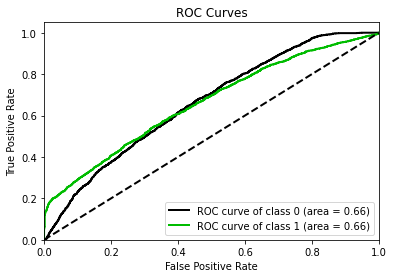

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.532
NPV : 0.823
SEN : 0.573
SPC : 0.798
------------------------------


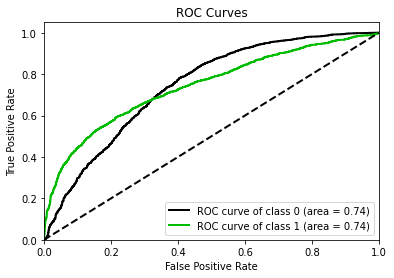

CPU times: user 1.43 s, sys: 802 ms, total: 2.23 s
Wall time: 3.22 s


In [8]:
%%time
Xdata_iso = acidoCEST_ML[['4.2','5.6']]
Ydata = acidoCEST_ML.pH

two_freqs = classify_pH_Log_Reg(Xdata_iso,Ydata, cut_offs=[6.5,7.0], Ncs=Ncs)

## - 4.2 ppm, 5.6 ppm, exp data

In [9]:
len(['4.2','5.6'] + exper_cols)

8

In [10]:
print(exper_cols)

['ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)', 'SatTime(ms)', 'ExpT1(ms)', 'ExpT2(ms)']


 row = 20,000 | cols = 8
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.854
NPV : 0.458
SEN : 0.624
SPC : 0.749
------------------------------


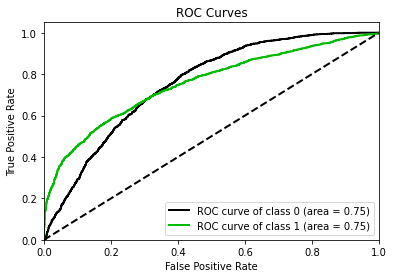

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.485
NPV : 0.868
SEN : 0.648
SPC : 0.77
------------------------------


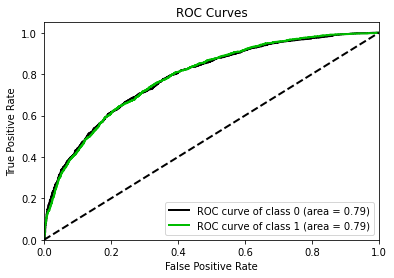

CPU times: user 2.06 s, sys: 415 ms, total: 2.47 s
Wall time: 3.78 s


In [11]:
%%time

c = ['4.2','5.6'] + exper_cols

Xdata_iso_and_exp = acidoCEST_ML[c]
Ydata = acidoCEST_ML['pH'].apply(lambda x: np.round(x,1))

two_freqs_and_exp = classify_pH_Log_Reg(Xdata_iso_and_exp,Ydata, cut_offs=[6.5,7.0], Ncs=Ncs)

## - Only Zspectra

 row = 20,000 | cols = 81
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.937
NPV : 0.506
SEN : 0.72
SPC : 0.856
------------------------------


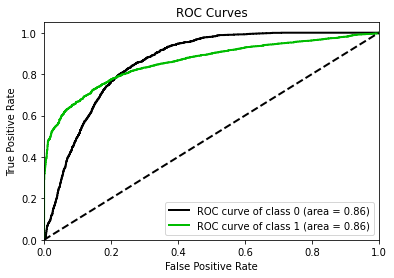

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.618
NPV : 0.911
SEN : 0.806
SPC : 0.8
------------------------------


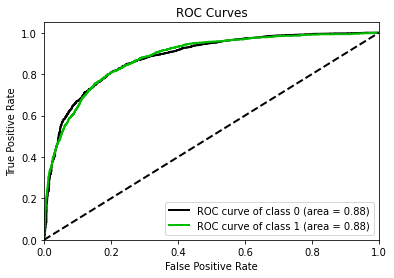

81 frequencies
6 exper cols
CPU times: user 29.2 s, sys: 427 ms, total: 29.7 s
Wall time: 10min 55s


In [12]:
%%time

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

only_zspectra = classify_pH_Log_Reg(Xdata,Ydata, cut_offs=[6.5,7.0], Ncs = Ncs)

print( f'{len(Xdata.columns)} frequencies' )
print( f'{len(exper_cols)} exper cols' )

## -  Zspectra  + exp data

 row = 20,000 | cols = 87
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.944
NPV : 0.513
SEN : 0.724
SPC : 0.872
------------------------------


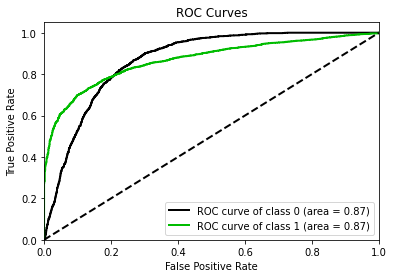

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END logistic__C=0.001, logistic__class_weight=balanced;, score=0.500 total time=   0.0s
[CV 3/3] END logistic__C=0.001, logistic__class_weight=balanced;, score=0.500 total time=   0.0s
[CV 3/3] END logistic__C=0.001, logistic__class_weight=None;, score=0.500 total time=   0.0s
[CV 2/3] END logistic__C=0.0027825594022071257, logistic__class_weight=balanced;, score=0.585 total time=   0.0s
[CV 1/3] END logistic__C=0.0027825594022071257, logistic__class_weight=None;, score=0.500 total time=   0.0s
[CV 3/3] END logistic__C=0.0027825594022071257, logistic__class_weight=None;, score=0.500 total time=   0.0s
[CV 1/3] END logistic__C=0.007742636826811269, logistic__class_weight=balanced;, score=0.579 total time=   0.0s
[CV 3/3] END logistic__C=0.007742636826811269, logistic__class_weight=balanced;, score=0.571 total time=   0.0s
[CV 1/3] END logistic__C=0.021544346900318832, logistic__class_weight=ba

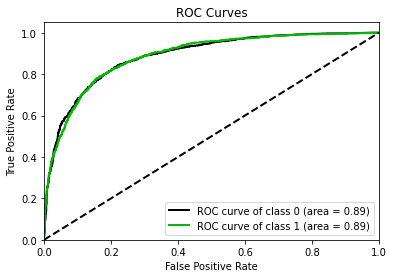

87
CPU times: user 29 s, sys: 497 ms, total: 29.5 s
Wall time: 11min 27s


In [13]:
%%time

Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

all_data = classify_pH_Log_Reg(Xdata,Ydata, cut_offs=[6.5,7.0], Ncs= Ncs)
print( len( list(Xdata.columns) ) )

## -- Coeff

In [14]:
plt.style.use('tableau-colorblind10')

                   Coeff
ExpT1(ms)       0.611395
ExpT2(ms)       1.365669
ExpB1(percent)  1.103067
ExpB0(Hz)       0.111837
SatPower(uT)    1.595702
SatTime(ms)     1.044235
-12             0.998826


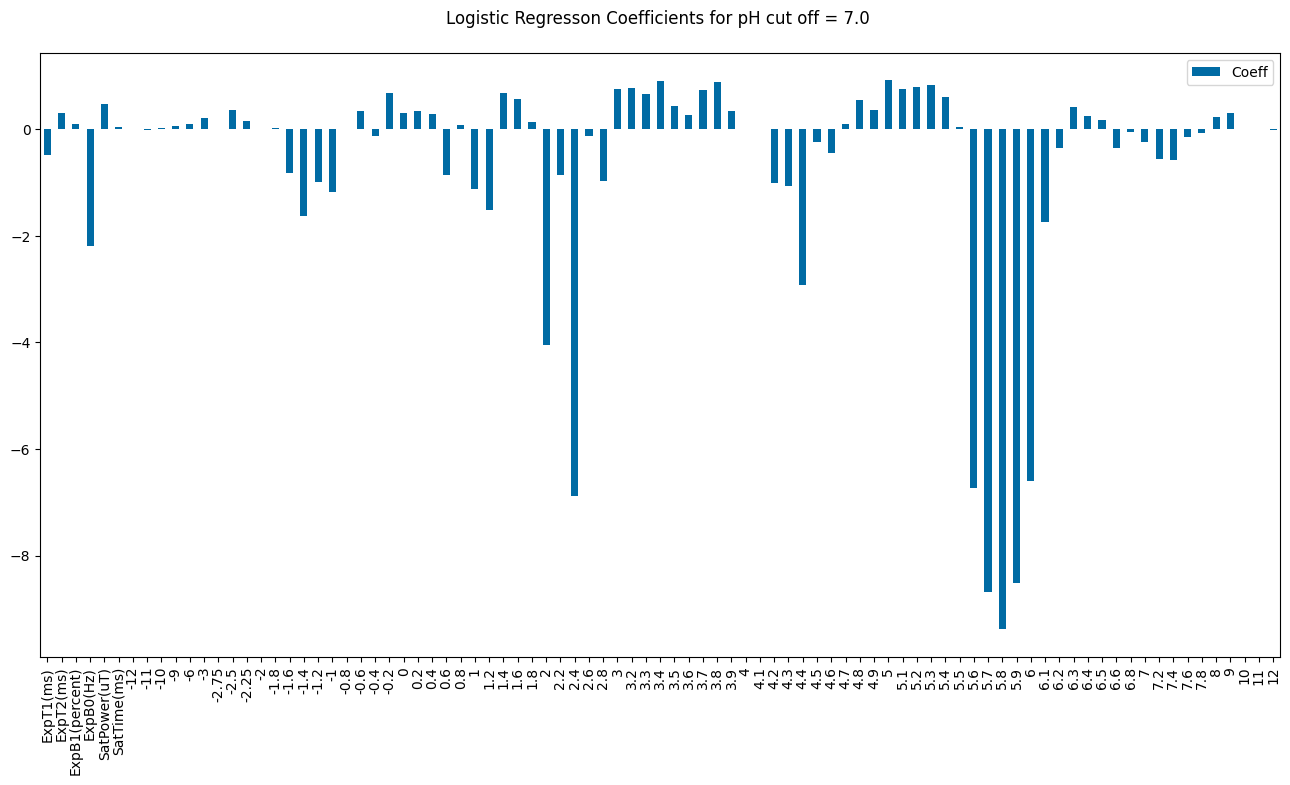

In [15]:
coef = all_data['7.0']['logistic'].coef_

C = pd.DataFrame(1-np.exp(coef.reshape(-1,1)),index=acidoCEST_ML.drop( ['pH'],axis=1).columns, columns=['Coeff' ])
print(np.exp(C.head(7)))
_, ax = plt.subplots(dpi=100, figsize=(16,8))
C.plot(kind='bar',ax=ax,rot=90)
plt.title('Logistic Regresson Coefficients for pH cut off = 7.0 \n')
plt.savefig('../figs/Figure_01_Classification.png',bbox_inches='tight')
plt.show()

                   Coeff
ExpT1(ms)       1.172224
ExpT2(ms)       0.985150
ExpB1(percent)  1.020042
ExpB0(Hz)       0.307338
SatPower(uT)    0.660087
SatTime(ms)     1.097723
-12             0.953750


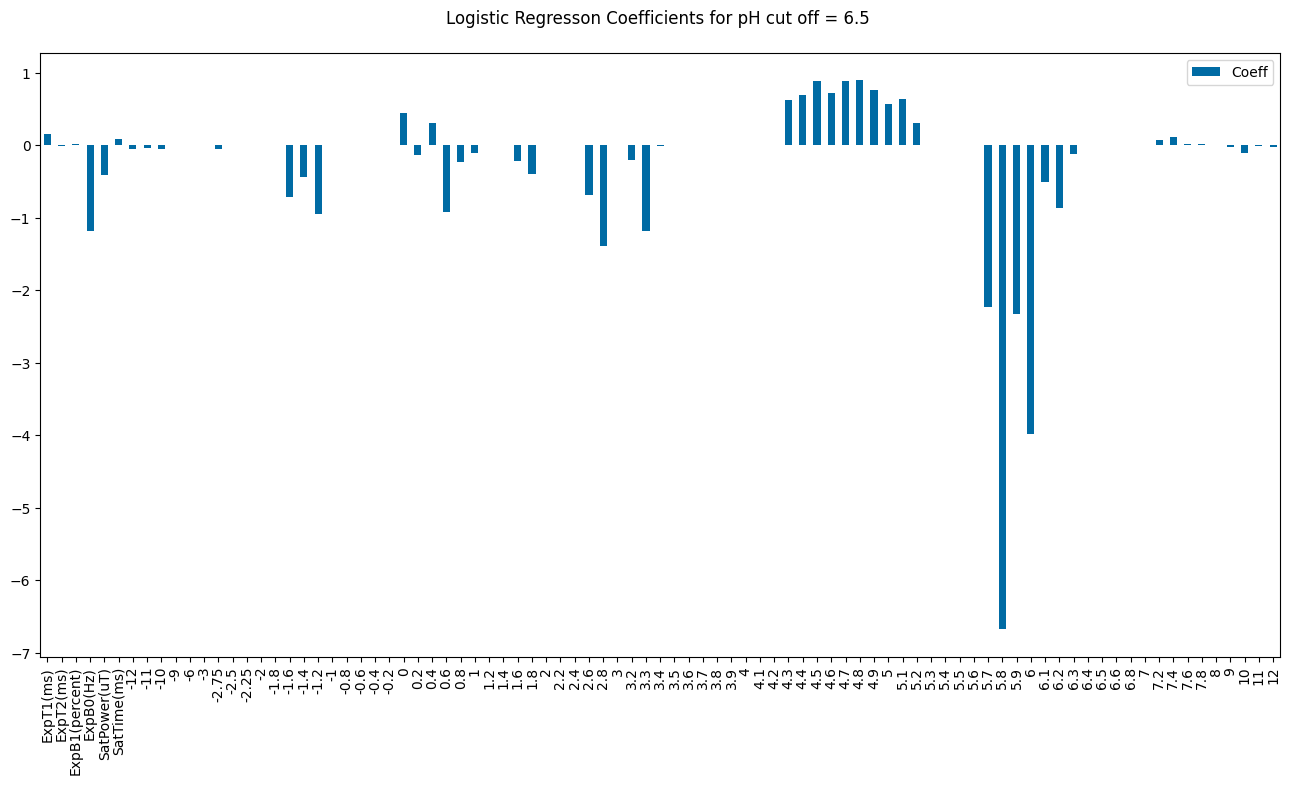

In [16]:
coef = all_data['6.5']['logistic'].coef_

C = pd.DataFrame(1-np.exp(coef.reshape(-1,1)),index=acidoCEST_ML.drop( ['pH'],axis=1).columns, columns=['Coeff' ])
print(np.exp(C.head(7)))
_, ax = plt.subplots(dpi=100, figsize=(16,8))
C.plot(kind='bar',ax=ax,rot=90)
plt.title('Logistic Regresson Coefficients for pH cut off = 6.5 \n')

plt.savefig('../figs/Figure_02_Classification.png',bbox_inches='tight')
plt.show()

## -- Feature Selection and Log Reg on selected features

22
 row = 20,000 | cols = 22
======  pH = 6.5 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.92
NPV : 0.478
SEN : 0.702
SPC : 0.817
------------------------------


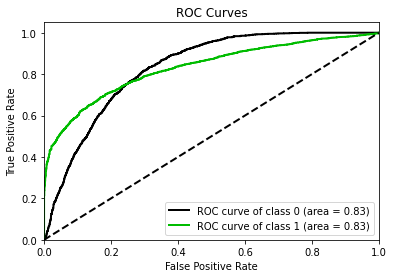

======  pH = 7.0 ====== 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Classification Performance 

PPV : 0.574
NPV : 0.897
SEN : 0.78
SPC : 0.768
------------------------------


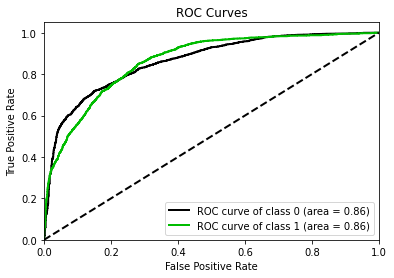

CPU times: user 3.68 s, sys: 443 ms, total: 4.12 s
Wall time: 48.5 s


In [17]:
%%time

def select_cols(coefficients):
    d = np.exp(coefficients)
    f= (d >1.90) | (d < 0.10)
    cols = np.array(Xdata.columns.values)
    new_cols = cols[f.reshape(-1,)]

    return new_cols
    
coef1 = all_data['7.0']['logistic'].coef_
coef2 = all_data['6.5']['logistic'].coef_

s1 = set(select_cols(coef1))
s2 = select_cols(coef2)

new_cols = list(s1.union(s2))
new_cols.sort()

print(len(new_cols))

Xdata_small = acidoCEST_ML.drop( ['pH'],axis=1)[new_cols]
Ydata = acidoCEST_ML.pH

all_data_small = classify_pH_Log_Reg(Xdata_small,Ydata, cut_offs=[6.5,7.0], Ncs=Ncs)

In [18]:
print(f'The following features were selected for Logistic Regression: \n {new_cols}')

The following features were selected for Logistic Regression: 
 ['-1', '-1.2', '-1.4', '0.6', '1', '1.2', '2', '2.4', '2.8', '3.3', '3.4', '4.2', '4.3', '4.4', '5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', 'ExpB0(Hz)']


In [19]:
# save output
all_data_small_change_in_odds = pd.DataFrame(all_data_small['6.5']['logistic'].coef_.reshape(-1,1),index=new_cols, columns=['6.5'])
all_data_small_change_in_odds['7.0'] = all_data_small['7.0']['logistic'].coef_.reshape(-1,1)
all_data_small_change_in_odds = all_data_small_change_in_odds.applymap(lambda f: np.exp(f) - 1).round(2)
all_data_small_change_in_odds.to_csv('../outputs/classification_change_in_odds_selected.csv')

In [20]:
#  save pipelines
from joblib import dump, load
dump(all_data_small['6.5'], '../models/pH_classication_pipeline_6p5.joblib') 
dump(all_data_small['7.0'], '../models/pH_classication_pipeline_7p0.joblib') 

['../models/pH_classication_pipeline_7p0.joblib']

# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier as RFC

def train_RFC(Spectra, pH_observed, pH_cut_off = 7.0):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # Logistic
    rf = RFC(random_state=42, n_jobs=10)
    
    param_grid ={
    'n_estimators': [5,10,20,50,100],
    'max_depth': [2,4,8,10,20] ,
        'class_weight':['balanced',None] ,
        'criterion':['entropy','gini']
    }
    
    estimator = GridSearchCV(rf, param_grid, verbose = 1, cv = 3, n_jobs=6, scoring=metrics.make_scorer( metrics.balanced_accuracy_score))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    
    # CLASSIFC
    classification_per = classification_metrics(y_test, estimator.predict(X_test))
    print('Classification Performance \n')
    [print(f'{key} : {value}') for key, value in classification_per.items()]
    print('---'*10)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)

    plt.show()
    
    return estimator.best_estimator_
    
    

## -- 4.2 and 5.6 only

############ pH = 6.5############
[CV 1/3] END logistic__C=0.0027825594022071257, logistic__class_weight=None;, score=0.505 total time=   5.1s
[CV 1/3] END logistic__C=0.007742636826811269, logistic__class_weight=balanced;, score=0.749 total time=   5.2s
[CV 2/3] END logistic__C=0.007742636826811269, logistic__class_weight=balanced;, score=0.761 total time=   5.0s
[CV 2/3] END logistic__C=0.007742636826811269, logistic__class_weight=None;, score=0.596 total time=   5.2s
[CV 1/3] END logistic__C=0.021544346900318832, logistic__class_weight=balanced;, score=0.775 total time=   7.8s
[CV 3/3] END logistic__C=0.021544346900318832, logistic__class_weight=balanced;, score=0.779 total time=   6.3s
[CV 2/3] END logistic__C=0.021544346900318832, logistic__class_weight=None;, score=0.659 total time=   8.0s
[CV 1/3] END logistic__C=0.05994842503189409, logistic__class_weight=balanced;, score=0.784 total time=   8.4s
[CV 3/3] END logistic__C=0.05994842503189409, logistic__class_weight=balanced;, sc

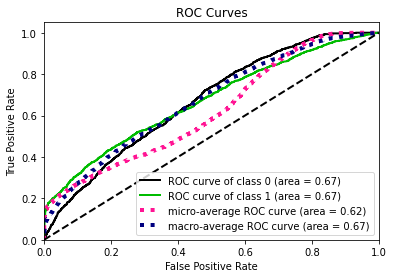

CPU times: user 3.03 s, sys: 404 ms, total: 3.44 s
Wall time: 15.8 s


<AxesSubplot: >

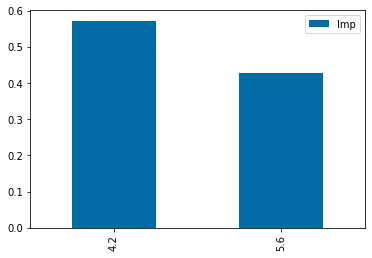

In [22]:
%%time

pH = 6.5

print('==='*20)
print('############ pH = {}############'.format(pH))
Xdata = acidoCEST_ML[['4.2','5.6']]
Ydata = acidoCEST_ML.pH
RF_two_freqs_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

############ pH = 7.0############
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.547
NPV : 0.823
SEN : 0.566
SPC : 0.812
------------------------------


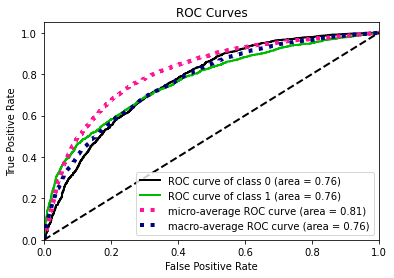

CPU times: user 2.22 s, sys: 192 ms, total: 2.41 s
Wall time: 13.7 s


<AxesSubplot: >

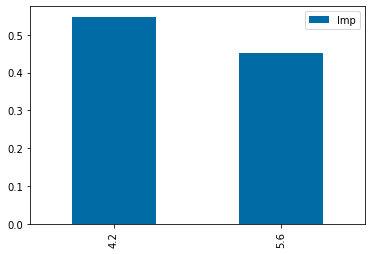

In [23]:
%%time

pH = 7.0

print('==='*20)
print('############ pH = {}############'.format(pH))
Xdata = acidoCEST_ML[['4.2','5.6']]
Ydata = acidoCEST_ML.pH
RF_two_freqs_70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

## -- 4.2 and 5.6  and  non-CEST exp data

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.996
NPV : 0.998
SEN : 0.999
SPC : 0.989
------------------------------


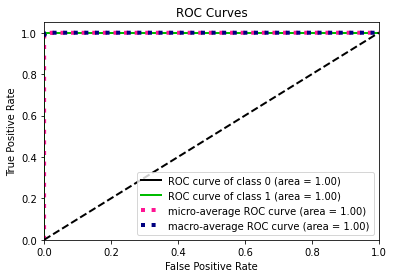

CPU times: user 3.37 s, sys: 227 ms, total: 3.59 s
Wall time: 13.2 s


<AxesSubplot: >

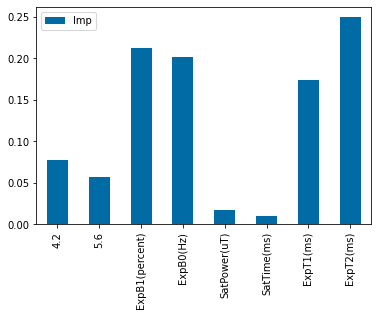

In [24]:
%%time

c = ['4.2','5.6'] + exper_cols
pH = 6.5

Xdata = acidoCEST_ML[c]
Ydata = acidoCEST_ML.pH

RF_two_freqs_and_exp65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_and_exp65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

In [25]:
print(RF_two_freqs_and_exp65)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, n_jobs=10, random_state=42)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 1.0
NPV : 0.998
SEN : 0.996
SPC : 1.0
------------------------------


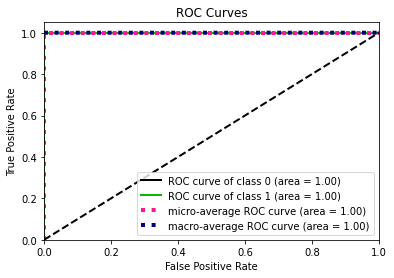

CPU times: user 3.54 s, sys: 251 ms, total: 3.79 s
Wall time: 13.5 s


<AxesSubplot: >

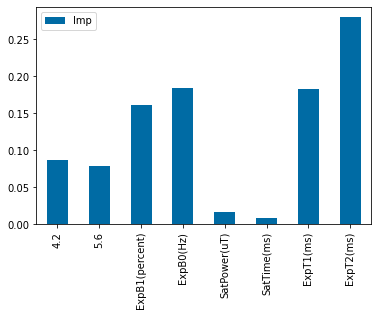

In [26]:
%%time

c = ['4.2','5.6'] + exper_cols
pH = 7.0

Xdata = acidoCEST_ML[c]
Ydata = acidoCEST_ML.pH

RF_two_freqs_and_exp70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)
pd.DataFrame(RF_two_freqs_and_exp70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar')

## -- All sat freqs 

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.935
NPV : 0.558
SEN : 0.779
SPC : 0.837
------------------------------


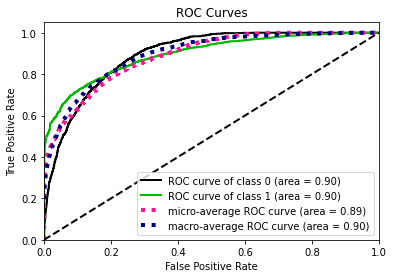

CPU times: user 16.3 s, sys: 290 ms, total: 16.6 s
Wall time: 1min 1s


<AxesSubplot: >

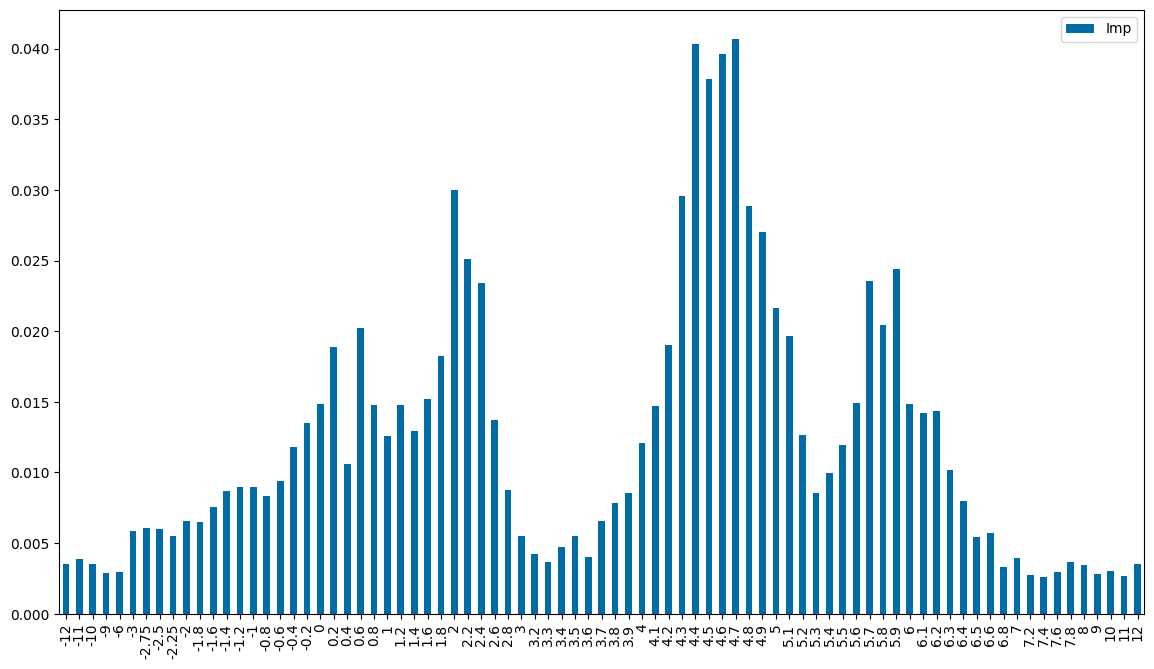

In [27]:
%%time

pH = 6.5

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_freqs65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_freqs65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.751
NPV : 0.912
SEN : 0.785
SPC : 0.896
------------------------------


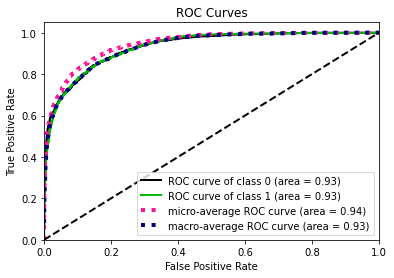

CPU times: user 12.7 s, sys: 294 ms, total: 13 s
Wall time: 1min


<AxesSubplot: >

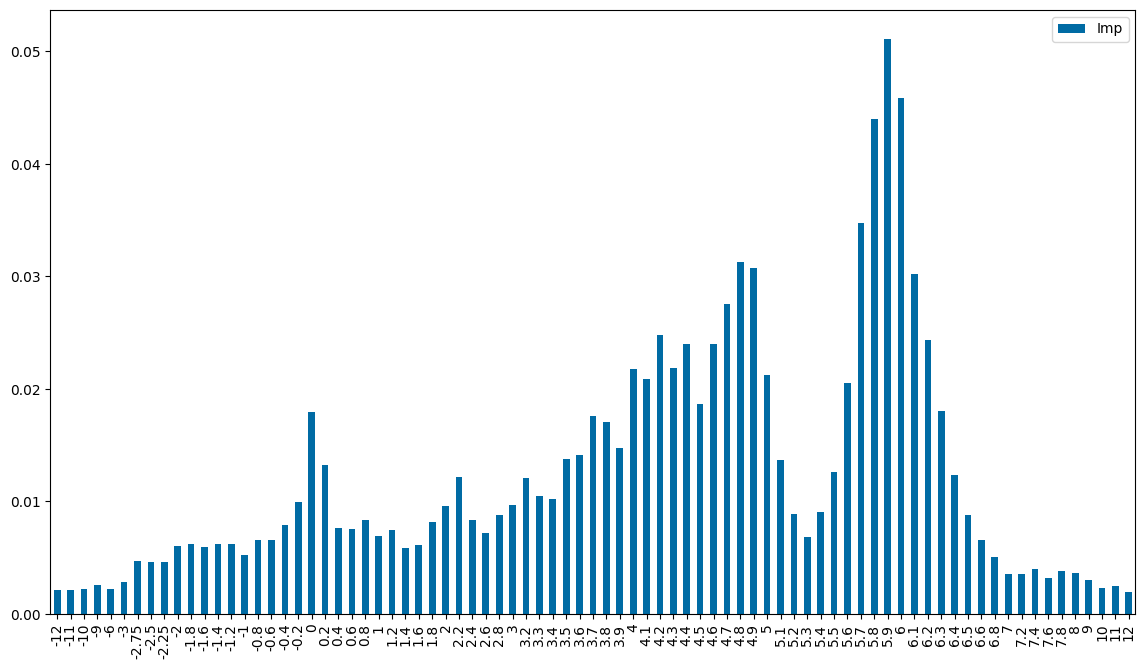

In [28]:
%%time

pH = 7.0

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_freqs70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_freqs70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

## -- All data

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.964
NPV : 0.605
SEN : 0.802
SPC : 0.91
------------------------------


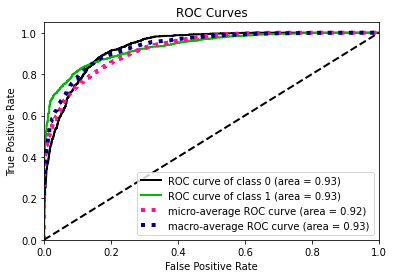

CPU times: user 16.1 s, sys: 348 ms, total: 16.4 s
Wall time: 1min


<AxesSubplot: >

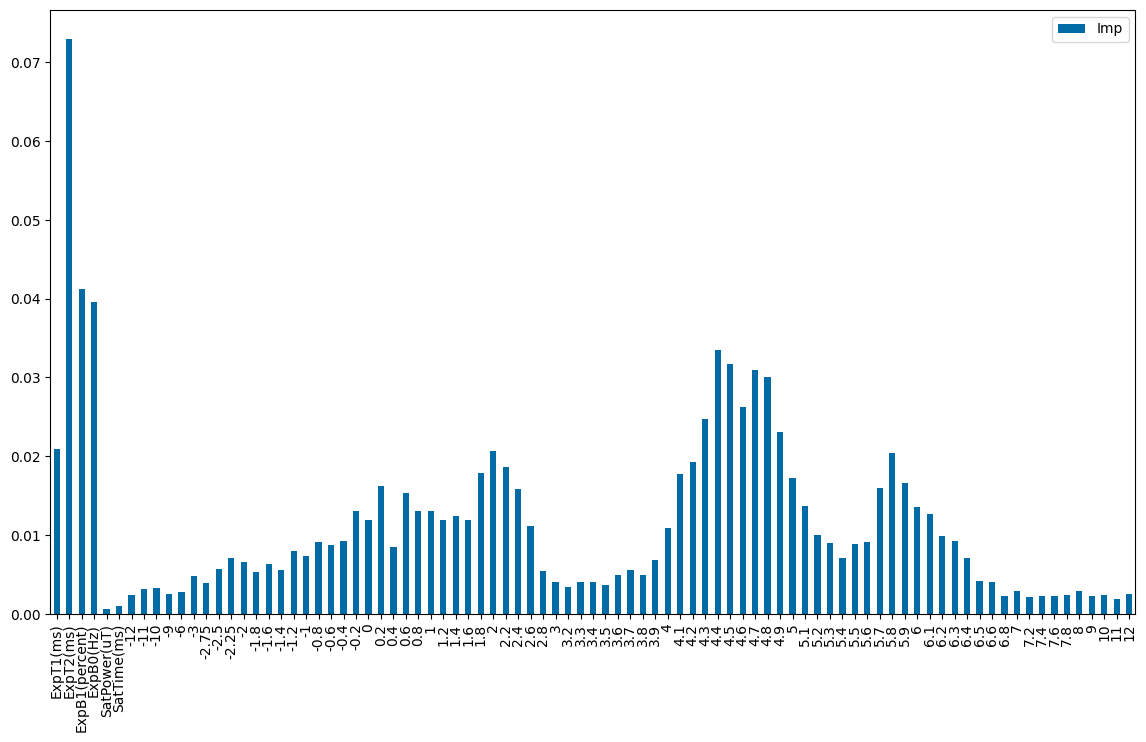

In [29]:
%%time


pH = 6.5

Xdata = acidoCEST_ML.drop(['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_data65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_data65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.847
NPV : 0.91
SEN : 0.768
SPC : 0.944
------------------------------


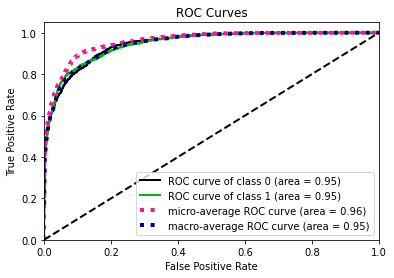

CPU times: user 15.9 s, sys: 299 ms, total: 16.2 s
Wall time: 1min 1s


<AxesSubplot: >

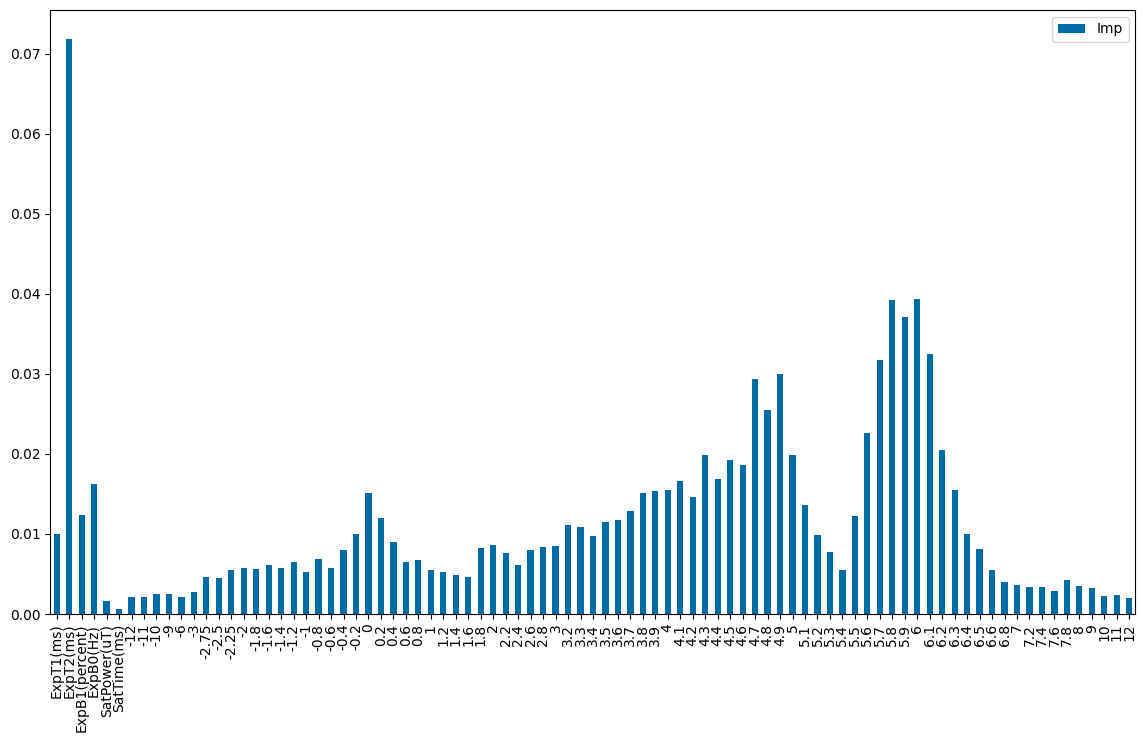

In [30]:
%%time

pH = 7.0

Xdata = acidoCEST_ML.drop(['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

RF_all_data70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_all_data70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

## -- Selected features

In [31]:
s1 = set(pd.DataFrame(RF_all_data65.feature_importances_, index=Xdata.columns, columns=['Imp']).sort_values('Imp',ascending=False).head(20).index)
s2 = set(pd.DataFrame(RF_all_data70.feature_importances_, index=Xdata.columns, columns=['Imp']).sort_values('Imp',ascending=False).head(20).index)
sel_f = list(s1.union(s1))
sel_f.sort()
print(f'The following features were selected for Random Forest are : \n {sel_f}')

The following features were selected for Random Forest are : 
 ['0.2', '1.8', '2', '2.2', '4.1', '4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.8', '5.9', 'ExpB0(Hz)', 'ExpB1(percent)', 'ExpT1(ms)', 'ExpT2(ms)']


In [32]:
len(sel_f)

20

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.967
NPV : 0.953
SEN : 0.985
SPC : 0.9
------------------------------


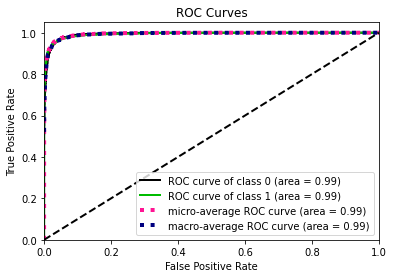

CPU times: user 9.51 s, sys: 282 ms, total: 9.79 s
Wall time: 28.4 s


<AxesSubplot: >

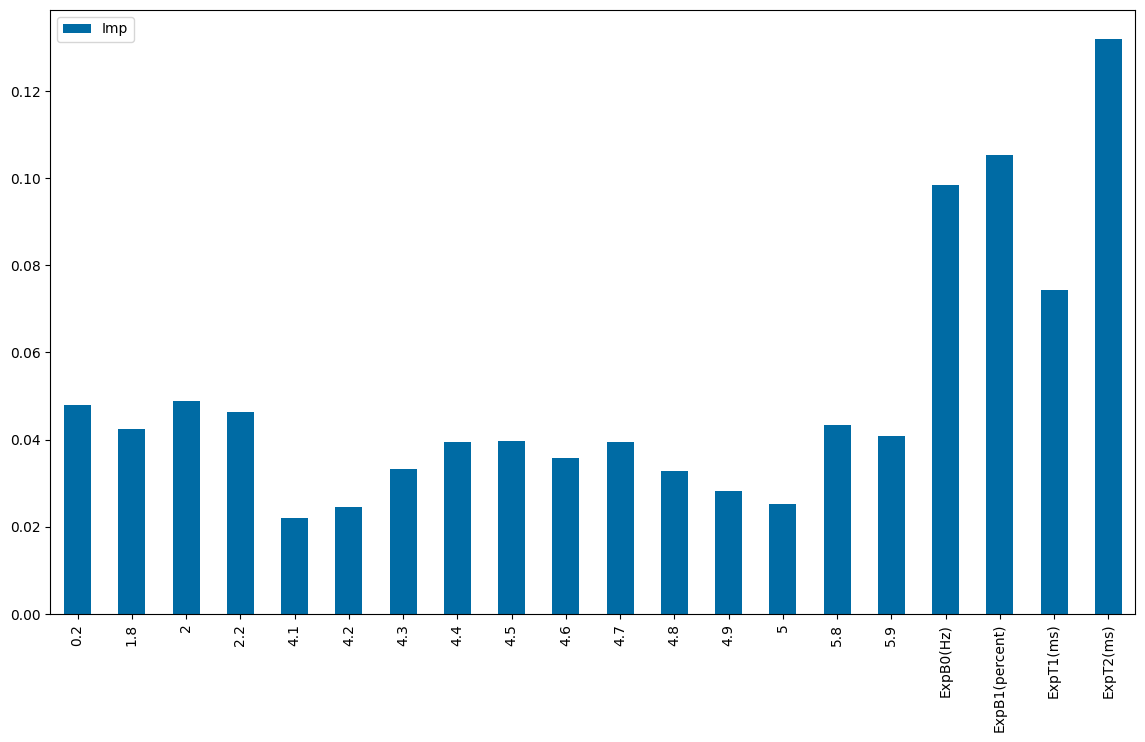

In [33]:
%%time

pH = 6.5

Xdata = acidoCEST_ML[sel_f]
Ydata = acidoCEST_ML.pH 

RF_set_features_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.961
NPV : 0.943
SEN : 0.851
SPC : 0.986
------------------------------


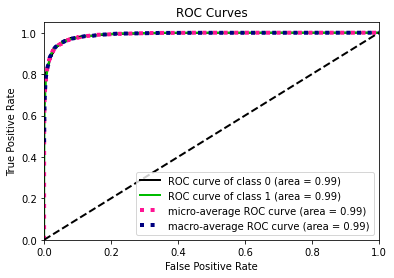

CPU times: user 9.83 s, sys: 265 ms, total: 10.1 s
Wall time: 29 s


<AxesSubplot: >

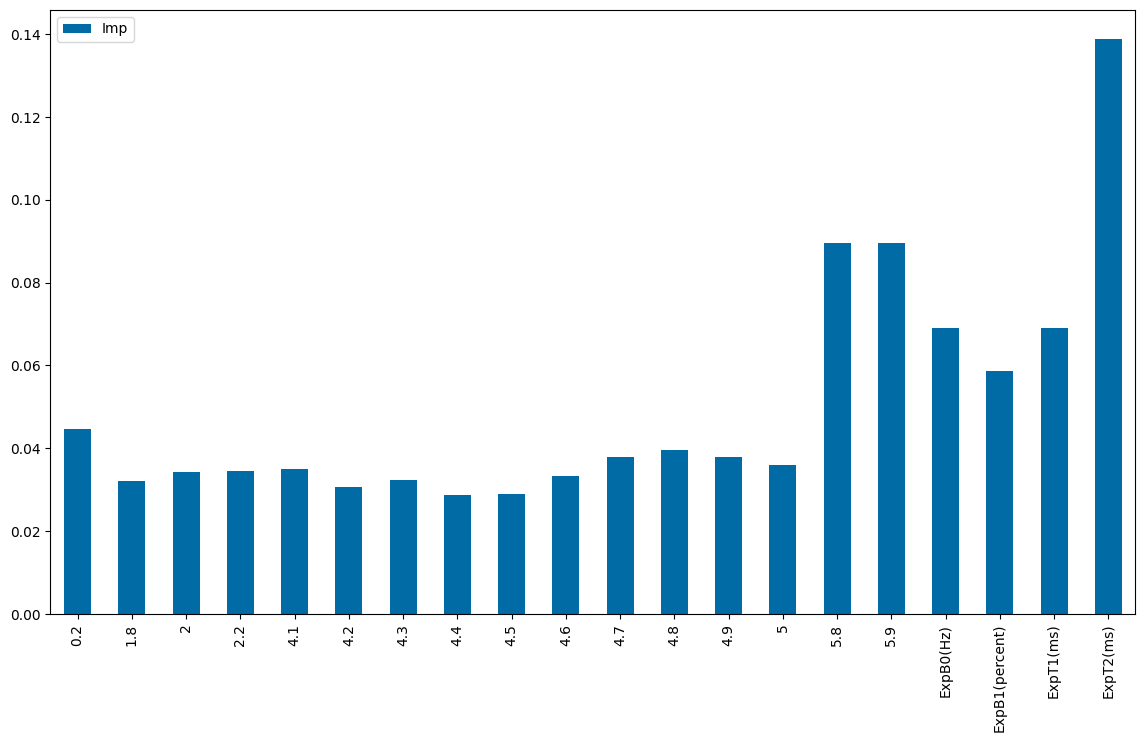

In [34]:
%%time

pH = 7.0

Xdata = acidoCEST_ML[sel_f]
Ydata = acidoCEST_ML.pH 

RF_set_features_70 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_70.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

In [35]:
# save models for RF
# clf = load('filename.joblib') 
# https://scikit-learn.org/stable/modules/model_persistence.html
dump( RF_set_features_65, '../models/pH_classication_random_forest_6p5.joblib') 
dump( RF_set_features_70, '../models/pH_classication_random_forest_7p0.joblib') 

['../models/pH_classication_random_forest_7p0.joblib']

## Tree Vis

In [36]:
%%capture
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


new_names = []

for i,x in enumerate(sel_f):
    if x.split('.')[0].isnumeric() == True:
        new_names.append( f'{x} ppm' )
        
    else:
        new_names.append( x.split('(')[0].split('Exp')[1] )


        
        
tree=RF_set_features_70.estimators_[9]

classes = list( pd.Series(tree.classes_).replace([0,1],[' pH < 7', 'pH > 7']).values )

fig = plt.figure(dpi=500)
plot_tree( tree,  feature_names = new_names, class_names= classes,
          filled=True, impurity=False,  max_depth = 4, fontsize = 4, label='none', proportion =True,
          rounded=False);

plt.savefig('../figs/Tree_example_max_depth_04_tree09.png',bbox_inches='tight')

In [37]:
from  sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(tree, 
                 out_file='tree09_04_levels.dot', 
                feature_names = new_names,
                class_names = classes,
                max_depth = 4 ,
                rounded = True, proportion = False, 
                precision = 2, filled = True, leaves_parallel=True, rotate=True)

In [38]:
from sklearn.tree import export_text

tree_as_text_09 = export_text(RF_set_features_70.estimators_[9]
                  ,  max_depth = 4
                  ,  decimals = 3
                  ,  spacing = 3
                  , feature_names = new_names 
                  , show_weights=True )   

print(tree_as_text_09)

|--- 4.3 ppm <= 0.805
|   |--- 5.9 ppm <= 0.837
|   |   |--- T2 <= 231.375
|   |   |   |--- B1 <= 110.825
|   |   |   |   |--- 4.3 ppm <= 0.750
|   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |--- 4.3 ppm >  0.750
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- B1 >  110.825
|   |   |   |   |--- 2.2 ppm <= 0.631
|   |   |   |   |   |--- weights: [0.000, 119.762] class: 1.0
|   |   |   |   |--- 2.2 ppm >  0.631
|   |   |   |   |   |--- weights: [1.405, 0.000] class: 0.0
|   |   |--- T2 >  231.375
|   |   |   |--- 4.3 ppm <= 0.757
|   |   |   |   |--- 4.9 ppm <= 0.747
|   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |--- 4.9 ppm >  0.747
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- 4.3 ppm >  0.757
|   |   |   |   |--- 5.8 ppm <= 0.801
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- 5.8 ppm >  0.801
|   |   |   |   |   |--- truncated branch of depth 9
|   |--- 5.9 ppm >  0.

## -- Selected features (without B1)

### - LASSO

not needed because B1 was not selected

### - random forest

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.963
NPV : 0.589
SEN : 0.789
SPC : 0.908
------------------------------


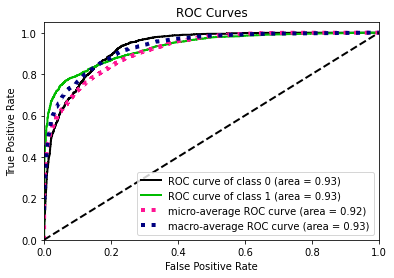

CPU times: user 7.58 s, sys: 254 ms, total: 7.84 s
Wall time: 27.7 s


<AxesSubplot: >

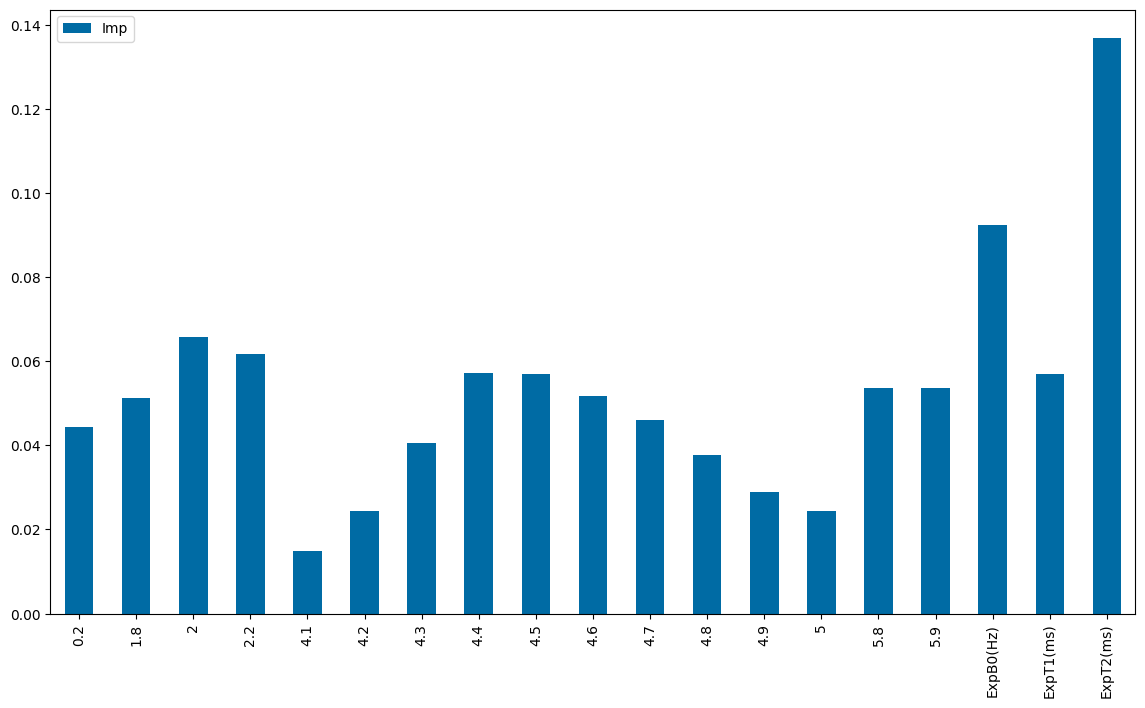

In [39]:
%%time

pH = 6.5
preds = [x for x in sel_f  if 'B1' not in x ]

Xdata = acidoCEST_ML[preds]
Ydata = acidoCEST_ML.pH 

RF_set_features_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Classification Performance 

PPV : 0.942
NPV : 0.931
SEN : 0.819
SPC : 0.98
------------------------------


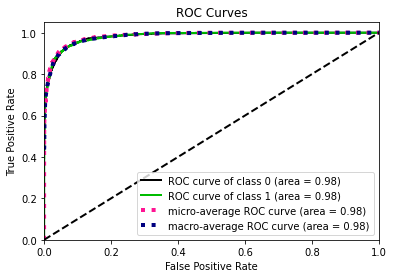

CPU times: user 9.9 s, sys: 249 ms, total: 10.1 s
Wall time: 29.3 s


<AxesSubplot: >

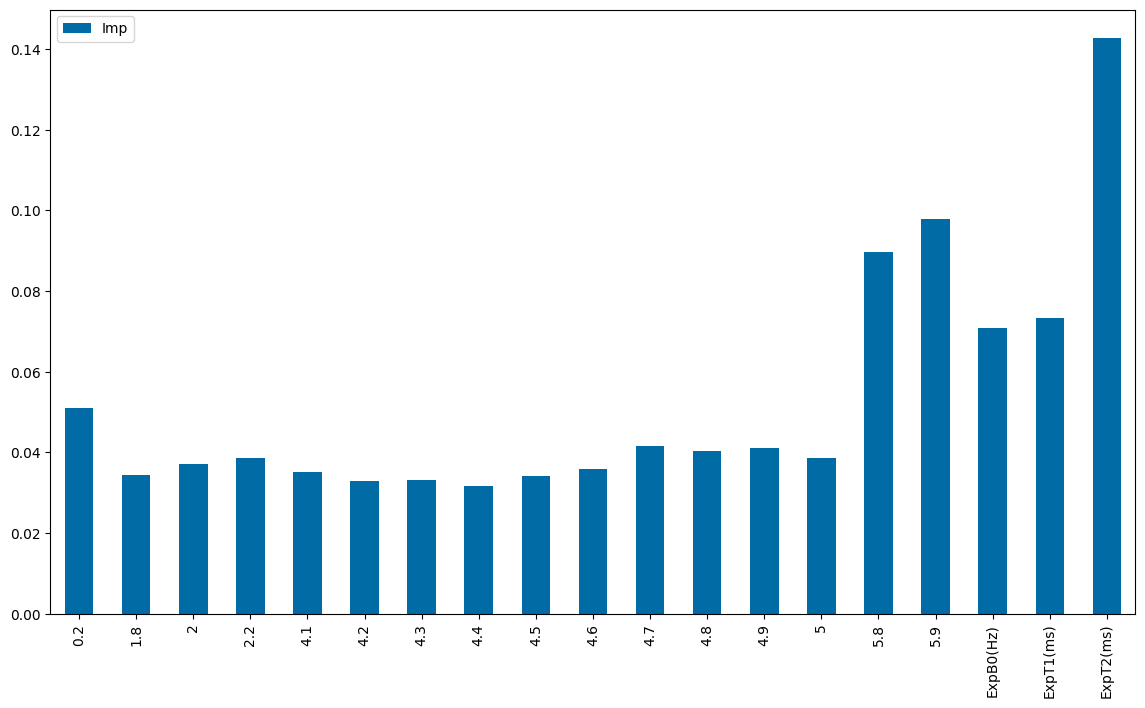

In [40]:
%%time

pH = 7.
preds = [x for x in sel_f  if 'B1' not in x ]

Xdata = acidoCEST_ML[preds]
Ydata = acidoCEST_ML.pH 

RF_set_features_65 = train_RFC(Xdata,Ydata, pH_cut_off= pH)

_ , ax = plt.subplots(dpi=100, figsize=(14,8))
pd.DataFrame(RF_set_features_65.feature_importances_, index=Xdata.columns, columns=['Imp']).plot(kind='bar',ax=ax)